# Using Deep Learning Libraries to Solve Stochastic Differential Equations
<br/>

<!---
<div class="img_row">
	<img class="col three" src="{{ site.baseurl }}/img/dlbio_header.png" alt="" title="dlbio_header"/>
</div>
<div class="col three caption">
</div>
-->

I am sure that most of you have heard about many of the deep learning libraries out there including `TensorFlow`, `Theano`, `Keras` and `PyTorch`. They facilitate building of layered and potentially complex neural network models for areas as diverse as automatic image captioning, speech recognition, and drug design. Undoubtedly and for better or worse, the deep learning field is riding on a wave of hype. The good thing about it is definitely that the deep learning libraries keep developing at astonishing pace. In this article, I will make use of these developments to implement two stochastic models from systems biology and solve them efficiently using the [computational graph paradigm](http://www.cs.cornell.edu/courses/cs5740/2017sp/lectures/04-nn-compgraph.pdf) of `Theano` and `TensorFlow`.

## Generalized diffusion process
<br/>
In systems biology, quantitative finance, statistical physics and beyond, one often needs to solve a **stochastic differential equation (SDE)** to obtain a trustworthy model of the dynamics of studied system. This equation often takes the form of a generalized diffusion process:

$$
dX(t) = A\big(X(t)\big) \cdot dt + B\big(X(t)\big) \cdot W(t) \tag{1}
$$

where the first term on the right-hand side is *drift term* and the second term is *diffusion term*. You can think about this as pouring few drops of dyed liquid into a river stream. The color will both be carried along with the current (drift) and, to great delight of all witnessing environmental activists, gradually spread across the river width (diffusion). Diffusion is a random process and this is why the model term includes \\(W(t)\\), [*Wiener process*](https://en.wikipedia.org/wiki/Wiener_process) which follows normal distribution with mean \\(0\\) and variance \\(\Delta t\\) (white noise).

In my [previous blog post](http://www.martinholub.com/eth/code/2018/04/15/stochsim.html), I discussed modeling of biochemical reaction networks using the *chemical master equation* (CME). One of its drawbacks was significant computational cost. It turns out that the equation \\((1)\\) is a **Fokker-Planck equation**, continuous approximation of the system state dynamics (goodbye copy numbers, welcome back concentrations) and as such, it is cheaper to draw samples from.

## Numerical methods for SDEs
<br/>
Solution to such type of equations can be found analytically only in rare (and usually pretty boring) cases. Luckily we can adapt some of the workhorses of numerical mathematics for solutions of ordinary differential equations (ODEs) like [*Euler* or *Runge-Kutta*](https://render.githubusercontent.com/view/ipynb?commit=db14f71f8b87cd9292cd15425de9bf9a512f4584&enc_url=68747470733a2f2f7261772e67697468756275736572636f6e74656e742e636f6d2f6d617274696e686f6c75622f73746f636861737469632d70726f6365737365732d6b796f746f5578303039782f646231346637316638623837636439323932636431353432356465396266396135313266343538342f30312e6970796e62&nwo=martinholub%2Fstochastic-processes-kyotoUx009x&path=01.ipynb&repository_id=129758771&repository_type=Repository#Euler-Scheme) methods to obtain a numerical solution.

##### Euler method
<br/>
The **Euler** method (also [**Euler-Maruyama**](https://en.wikipedia.org/wiki/Euler%E2%80%93Maruyama_method)) is straightforward extension of the deterministic variant that you have likely already heard of. Namely, given initial state \\(x(0)\\) it obtains consecutive states with the following rule:

$$
x(t+1) - x(t) = A\big(x(t)\big) \delta t + B\big(x(t)\big) \xi \delta t \tag{2}
$$

with \\(\delta t\\) 

$$
\delta t = \frac{t_{total}}{n_{steps}}
$$

being size of the time interval and \\(\xi \\) standard normal random numbers.

Being as straightforward as it is, the method has [strong convergence](http://snovit.math.umu.se/~david/Des2010/em_basel.pdf) only of the order of \\(\delta t ^{\frac{1}{2}}\\) (this basically says that to get twice as small error you need to make your time steps four times that small), which is poor.

##### 4th order Runge-Kutta method
<br/>
To come up with an improvement we have to look no further than at the familiar <a href="(https://en.wikipedia.org/wiki/Runge%E2%80%93Kutta_method_(SDE)">**4th order Runge-Kutta**</a> numerical scheme that offers strong convergence of the order of \\(\delta t \\). This is why I will be using this method in the following examples. The implementation here is slightly more involved, so checkout the code itself or the [reference](http://people.sc.fsu.edu/~jburkardt/m_src/stochastic_rk/rk4_ti_step.m) if you are interested in details.

## Biological system
<br/>
Now that I have described the tools for solving the involved equations, let's take a look at some examples of biological systems and model their dynamics!

### Bistable gene circuit
<br/>
Let's consider a system composed of two genes that express transcription factors that inhibit each other (see figure 1). Careful analysis shows that such system has three equilibria, one of which being unstable. As a result, if I initialize the system close to the unstable one, it will eventually tend to one of the two stable points (like you at the party! Sometimes you are in between but mostly are to be found either at the table with foods or drinks). At these two equilibrium points concentration of one of the species is low whereas of the other is high. (Think about it as trying to fit a clone of Chuck Norris into a room where the original one already resides. Any room would be too small to contain awesomeness of both and thus one needs to leave for the other to thrive.)

<!---
<div class="img_row">
	<img class="col three" src="{{ site.baseurl }}/img/bistable_circuit.png" alt="" title="Bistable Gene Circuit"/>
</div>
<div class="col three caption">
(a) Schematics of bistable gene circuit with two genes. (b) Phase diagram showing several trajectories converging to either one of the two stable equilibria. Along the dashed line, concentrations of both expressed transcription factors are equal corresponding to unstable equilibrium. [1]
</div>
-->


The system is described by following pair of equations:

$$
\frac{x_1}{dt} = \frac{\beta_1}{1+(x_2 / K_2)^n} - \gamma x_1
\qquad
\frac{x_2}{dt} = \frac{\beta_2}{1+(x_1 / K_1)^n} - \gamma x_2
\tag{3}
$$

where \\(\beta_i\\), \\(K_i\\) and \\(\gamma\\) are some constants (which values are not really important as long as they provide for \\(\dot{x}_i \approx 0\\) around the the unstable equilibrium) and \\(n\\) is the *Hill coefficient*. I will set \\(n \geq 2\\) which assures *cooperativity* of binding sites (here it serves the purpose of making the response of the system faster).

Starting from unstable initial condition \\(x_1 = x_2\\), I let the noise (the Wiener process term in Fokker-Planck equation) determine which stable equilibrium will the system state find.

### The Repressilator
<br/>
The "*repressilator*" is the simplest model of genetic circuit that permits sustained oscillations. It is due to the pioneering work of Elowitz and Leibler ([Nature, 2000](http://www.elowitz.caltech.edu/publications/Repressilator.pdf)) that devised the circuit and implemented it in living bacteria. You may think of this as very simple system, but be aware that oscillatory patterns are indeed present in nature and crucial to how we as organisms function. Prominent example being [circadian rhythm](https://en.wikipedia.org/wiki/Circadian_rhythm) that makes us function optimally on 24-hour day with sleeping time during the night (elucidation of its mechanism was honored by [2017 Nobel prize](https://en.wikipedia.org/wiki/Nobel_Prize_in_Physiology_or_Medicine)).

The model itself is not anyhow more complex than the one for bistable gene circuit. In fact, the repressilator (only one of multiple setups that permit oscillations), can be obtained from the bistable genetic circuit just by adding third repressing element. This gives the following set of equations:

$$
\frac{x_i}{dt} = \frac{\beta_i}{1+(x_j / K_j)^n} - \gamma x_i
\qquad
i = {1,2,3},\quad j = (i + 1)~\%~3 
\tag{4}
$$

<!---
<div class="img_row">
	<img class="col three" src="{{ site.baseurl }}/img/repressilator_full2.png" alt="" title="The Represillator Circuit"/>
</div>
<div class="col three caption">
<i>Left</i>: Schematics of the represillator circuit where three genes express transcription factors that repress each other in turn. <i>Right</i>: An original simulation (Elowitz, 2000) showing oscillations of individual protein concentrations. Here with specific proteins cI, lacI, tetR replacing the general A, B, C notation. [1]
</div>
-->

## Simulation with `Theano` and `TensorFlow`
<br/>
As the two above models are stochastic, I will have to generate many individual realizations to obtain good representation of the system's behavior. In order to do this efficiently, I will leverage the deep learning libraries that come with optimized implementations of [BLAS](https://en.wikipedia.org/wiki/Basic_Linear_Algebra_Subprograms) (Basic Linear Algebra Subprograms) libraries. In particular, I can run tens of thousands of individual parts simultaneously in just one or two seconds and that on my clunky old laptop's CPU. This is nice, especially if you need to debug your model and could use short development cycles or if your comprises of many species.

#### Selection of DL library
<br/>
When it comes to selection of a deep learning library, one has multiple choices. As here I am not building any complex deep learning model but rather want to use low level functions, I have the main choice between [*Theano*](http://deeplearning.net/software/theano/) and [*TensorFlow*](https://www.tensorflow.org/). I find the former slightly more intuitive to use and this why it would be my initial choice. However, late 2017 its core developers at LISA/MILA lab at the University of Montreal have announced that they [cease its further development](https://groups.google.com/forum/#!msg/theano-users/7Poq8BZutbY/rNCIfvAEAwAJ). This is why I also implemented a version that runs on `Tensorflow`, currently the most popular deep learning framework (as per number of stars on [github](https://github.com)).

#### Building and running a computational graph
<br/>
As I have already briefly mentioned in the introduction, the main point with using libraries like `Theano` and `TensorFlow` is that they implement different approach to computations compared to what you are probably used to. This can get pretty complicated so just keep in mind that working with the computational graphs in these libraries boils down to two phases: *building* and *execution*.

##### Building
Specifically, both libraries first express the mathematical operations symbolically, in a **computational graph** and optimize it for better performance and memory usage.  Computational graph (or data flow graph) is a directed acyclic graph ([DAG](https://en.wikipedia.org/wiki/Directed_acyclic_graph)) in which nodes correspond to mathematical operations ("Ops") and edges correspond to flow of intermediary values in between the nodes. The graph structure defines the dependencies between the operations (each node's output depends only on the node itself and its incoming edges) and thus their order of execution [[2]](http://u.cs.biu.ac.il/~yogo/nnlp.pdf).

##### Execution
Once the graph has been built (which can take some time as here is where the optimization happens), computing the *forward pass* through it is straightforward and usually quite swift. It amounts to traversing the nodes and computing the output of each node given the outputs of its predecessors. If parts of the graph are independent from the rest of the structure, they can be evaluated in parallel.

Great, now you know the basics of working with computational graphs! Let's go back to our examples from systems biology and build some models! Here, I will focus on the higher level implementation and results and omit the unnecessary details. Any time you feel like you need more context, you can grab the code in the [github repo](https://github.com/martinholub/demos-examples/blob/master/dl-bio) and have some fun with it. 

### Bistable gene circuit with `Theano`
<br/>
First I import the modules, including custom classes `Simulator` and `ModelParameters` (see full code on github), and set up some basic plotting parameters. Next, I initialize the `ModelParameters` and `Simulator` class objects with some parameters for the simulation

In [1]:
%load_ext autoreload
%autoreload 2
import theano
import numpy as np
import matplotlib.pyplot as plt
import time
from sde_theano import Simulator, ModelParameters
import matplotlib.gridspec as gridspec

plt.style.use('ggplot') # use "ggplot" style for graphs
pltparams = {'legend.fontsize':14,'axes.labelsize':18,'axes.titlesize':18,
             'xtick.labelsize':12,'ytick.labelsize':12,'figure.figsize':(7.5,7.5),}
plt.rcParams.update(pltparams)

theano.__version__.split("-")[0]

'0.9.0.dev'

In [2]:
total_time = 9
num_samples = 5e4
dt0 = 0.1
model = "switch"
mp = ModelParameters(num_samples, model_type = model, dt0 = dt0,
                     t_end = total_time, nspecies = 2)
sde_solver = Simulator(seed = 56, rv_shape = mp.x0.shape)

As introduced above, I first build a computational graph of the mathematical operations using [`theano.scan`](http://deeplearning.net/software/theano/library/scan.html) that is used for defining looping-like operations in the graph. Next, I compile it into a Python callable `sim` with [`theano.function`](http://deeplearning.net/software/theano/library/compile/function.html) such that I can call it as any other function.

In [3]:
# Define loop: symbolic description of the result and how to obtain it
# x_out ... 3D Tensor, updates ... dict , 
(x_out,updates)=theano.scan(fn = sde_solver.rk4_sde,   #stepping function
                            outputs_info = [mp.x],     #output shape
                            # set taps to [-1], dont specify IC
                            non_sequences = mp.params, #fixed parameters
                            n_steps = mp.nsteps)       # number of iterations

# Compile symbolic graph representation into callable function
sim=theano.function(inputs=mp.params,     # args to function
                    outputs=x_out,        # symbolic outputs
                    givens={mp.x:mp.x0},  # set initial value
                    updates=updates,      # how to obtain the outputs
                    allow_input_downcast=True,
                    profile=True)         # get time spent in ops

Subsequently, I can execute the compiled graph as usual. I also use [`graphviz`](http://www.graphviz.org/) to obtain nice visual rendering of the nodes and edges in the graph and even the results of profiling the code execution.

In [4]:
print("running sim...")
start = time.clock()
x_out = sim(*mp.params0)
diff = (time.clock() - start)
print("done in", diff, "s at ", diff/num_samples, "s per path")

running sim...
done in 3.0696229474693153 s at  6.13924589493863e-05 s per path


In [6]:
from theano.printing import pydotprint
from theano.d3viz import d3viz

pydotprint(sim, "pics/switch_graph.png", var_with_name_simple=True)
d3viz(sim, "pics/switch_graph.html")

The output file is available at pics/switch_graph.png


Here is the resulting visualization and here you can check the interactive <a href="{{ site.baseurl }}/img/switch_graph.png" target="_blank">`html`</a> output.

<!---
<div class="img_row">
    <a href="{{ site.baseurl }}/img/switch_graph.png" target="_blank">
	<img class="col three" src="{{ site.baseurl }}/img/switch_graph.png" alt="Graph Switch" title="Graph Switch"/></a>
</div>
<div class="col three caption">
Image of the computational graph with nodes representing mathematical operations or variables and edges representing flow of data ("tensors").
</div>
-->
Next, let's plot the results:

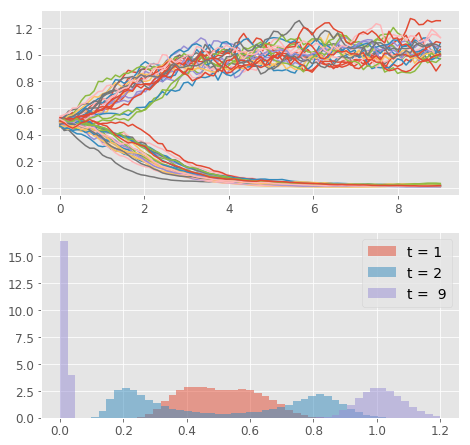

In [7]:
## for model SWITCH , nspecies = 2

downsample_factor_t = int(0.1/dt0) # show 10 points per time unit, here no downs.
downsample_factor_p = int(num_samples//50) ## show every 50th path
t = np.linspace(0, total_time, mp.nsteps//downsample_factor_t) # time axis

gs = gridspec.GridSpec(2, 1)

plt.subplot(gs[0, 0])
# plot just first of the two species
plt.plot(t, x_out[::downsample_factor_t, ::downsample_factor_p, 0])

plt.subplot(gs[1, 0])
bins = np.linspace(0, 1.2, 50)
plt.hist(x_out[int(1/dt0), :, 0], bins, alpha = 0.5, 
            normed=True, histtype='bar',  
            label=['t = 1'])
plt.hist(x_out[int(2/dt0), :, 0], bins, alpha = 0.5, 
            normed=True, histtype='bar',  
            label=['t = 2'])
plt.hist(x_out[-1, :, 0], bins, alpha = 0.5, 
            normed=True, histtype='bar',  
            label=['t =  9'])
plt.legend()
plt.show()

In the plot, you can clearly see that the system follows the announced behavior. The concentration of any of the two species (just one shown) starts in unstable equilibrium  and, based on the stochastic input, it evolves either to high or low stable equilibrium state. In the lower panel, you can see how the distribution of the concentration values changes in time. The example may seem trivial, but this is [indeed one of the mechanisms of cellular differentiation](https://doi.org/10.1016/j.cell.2011.01.030) permitting nongenetic cellular diversity. All things being equal, whether cell takes up fate A or B can be matter of pure chance (given our current level of understanding of determinism in biological systems :) )

### The Repressilator with `TensorFlow`

For the repressilator model, I will make use of `TensorFlow`'s implementation of `scan` function. Similar to the `Theano`'s version, `scan` allows to define loops in the computational graph paradigm.
First, we again import the required modules. Note that here I have replaced the custom `sde_theano` module with `sde_tflow` (full code on github). I then initialize instances of the custom classes `ModelParameters` and `Simulator` with some parameters for the simulation

In [1]:
%load_ext autoreload
%autoreload 2
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from sde_tflow import Simulator, ModelParameters
import matplotlib.gridspec as gridspec
import time

plt.style.use('ggplot') # use "ggplot" style for graphs
pltparams = {'legend.fontsize':14,'axes.labelsize':18,'axes.titlesize':18,
             'xtick.labelsize':12,'ytick.labelsize':12,'figure.figsize':(7.5,7.5),}
plt.rcParams.update(pltparams)

tf.__version__

'1.5.1'

In [2]:
total_time = 9
num_samples = 2.5e4
dt0 = 0.1
model = "rep"
mp = ModelParameters( num_samples, model_type = model,
                      dt0 = dt0, t_end = total_time)
sde_solver = Simulator(mp, seed = 56)

Next I build the computational graph and let `TensorFlow` optimize its structure. As I am using similar functionality as `Theano` the call does not differ much. I supply the function to evaluate at each execution, initial state and elements to loop over.

In [3]:
# Define loop: symbolic description of the result and how to obtain it
x_scan = tf.scan(fn = sde_solver.rk4_sde,        # stepping function
                    elems = sde_solver.rv_n,     # inputs for all steps
                    initializer = sde_solver.x0) # initial condition

With the graph built, I proceed to its execution (the forward pass through it). In `TensorFlow`, you run a graph in a [`tf.Session()`](https://www.tensorflow.org/programmers_guide/graphs#executing_a_graph_in_a_wzxhzdk132wzxhzdk133tfsessionwzxhzdk134wzxhzdk135) that encapsulates the environment the operations and tensors live in. Since a `tf.Session` owns a physical  resources, it is recommendable to use it as a context manager (in a `with` block) that automatically closes the session at the exit of the block.

Note that I also write the graph that is run in the session to a file in `log` folder. This graph can then be interactively visualized with [`TensorBoard`](https://www.tensorflow.org/programmers_guide/summaries_and_tensorboard). 

In [4]:
print("running sim...")
start = time.clock()

with tf.Session() as sess: # open a Session
    # Write the graph to file
    writer = tf.summary.FileWriter("log/", sess.graph) 
    x_out = sess.run(x_scan) # execute the graph
    writer.close() # close the FileWriter
    
diff = (time.clock() - start)
print("done in", diff, "s at ", diff/num_samples, "s per path")

running sim...
done in 3.599450070369931 s at  0.00014397800281479723 s per path


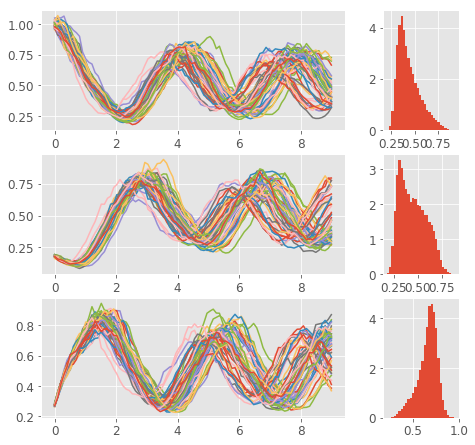

In [5]:
## for model REPRESILLATOR

downsample_factor_t = int(0.1/dt0) #always show 10 points per time unit
downsample_factor_p = int(num_samples//50)
t = np.linspace(0, total_time, mp.nsteps//downsample_factor_t)

gs = gridspec.GridSpec(3, 2, width_ratios=[4,1])

plt.subplot(gs[0, 0])
plt.plot(t, x_out[::downsample_factor_t, ::downsample_factor_p, 0])
plt.subplot(gs[1, 0])
plt.plot(t, x_out[::downsample_factor_t, ::downsample_factor_p, 1])
plt.subplot(gs[2, 0])
plt.plot(t, x_out[::downsample_factor_t, ::downsample_factor_p, 2])

plt.subplot(gs[0, 1])
plt.hist(x_out[-1,:,0], 30, 
            normed=True, histtype='bar')
plt.subplot(gs[1, 1])
plt.hist(x_out[-1,:,1], 30, 
            normed=True, histtype='bar')
plt.subplot(gs[2, 1])
plt.hist(x_out[-1,:,2], 30, 
            normed=True, histtype='bar')
plt.show()

Here are the results. You can nicely see the oscillatory pattern that however slowly degrades in time (this makes sense as the noise makes the paths more different). The paths for individual species are phase shifted such that each of the three reaches its maximum at different time. You can even save the histograms at couple of time steps and create an animation like this:

In [6]:
## Save plots for animation
plt.clf()
bins = np.linspace(0.1 , 1.1, 50)
for i in np.arange(x_out.shape[0]):
    plt.hist(x_out[i,:,1], bins, 
            normed=True, histtype='bar')
    plt.xlim([0.1, 1.1])
    plt.ylim([0, 10])
    plt.savefig("pics/tf/rep"+str(i)+".png")
    plt.clf()

<!---
<div class="img_row">
	<img class="col three" src="{{ site.baseurl }}/img/repressilator_anim.gif" alt="Repressilator Animation" title="Repressilator Animation"/>
</div>
<div class="col three caption">
Animation showing temporal evolution of concentrations of protein B in the repressilator model. 
</div>
-->

And here is a screenshot from the `TensorBoard` application. Unfortunately it is quite crowded and thus not well readable (it is much better inside `TensorBoard` as the graph is interactive).

<!---
<div class="img_row">
    <a href="{{ site.baseurl }}/img/tensorboard_repressilator.png" target="_blank">
	<img class="col three" src="{{ site.baseurl }}/img/tensorboard_repressilator.png" alt="" title="Tensorboard Represillator"/></a>
</div>
<div class="col three caption">
Image of the computational graph with nodes representing mathematical operations or variables and edges representing flow of data ("tensors") as rendered by TensorBoard.
</div>
-->

## Conclusion

In this post, I have shown you how to efficiently solve stochastic differential equation using computational graph approach implemented in deep learning libraries like `Theano` or `TensorFlow`. You can now develop these examples further and build a stochastic model of your own or even implement a neural network model in [virtually any domain of your interest](https://caffe2.ai/docs/applications-of-deep-learning.html). If you will do so, let me know, I am interested to hear about your experience.

<br/>
---
<br/>
### References

  \[1\]: Del Vecchio, D., Murray, R. M.; Biomolecular Feedback Systems  
  \[2\]: Goldber, Y.; A Primer on Neural Network Models for Natural Language Processing